## This is the second practical task of Sirius summer school "Applying AI for Med image analysis". 
Practical tasks take form of jupyter notebook with example code in the begging and some tasks in the end. Please, provide your solution in form of python code. Read hints, google a lot, don't hesitate to ask us directyl and most importatly - 
<span style="color:blue">have fun</span>.


**Topic**: Deep learning segmentation 

**To submit**: New version of the notebook, with your code. 

Loading dataset for segmentation is a bit different from simple classification. Below is full dataset class, which loads image and corresponding segmentation mask. 

In [ ]:
#to read mask files
!pip install imageio 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import imageio
import torch
from torch.utils.data import Dataset,DataLoader
import os 
import matplotlib.pyplot as plt
import albumentations as albu
from albumentations.core.composition import Compose
from albumentations.pytorch import ToTensor
from sklearn.model_selection import train_test_split

class LungSegmentationDataset(Dataset):
    def __init__(self,image_list,augmentations=None,transformations=None):
        self.path = "/content/drive/My Drive/Inno/data/Lung images from Bram"
        self.images = image_list
        self.augmentations = augmentations
        self.transformations = transformations
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,index):
        filename = self.images[index]
        image = imageio.imread(os.path.join(self.path,"Images/"+filename))
        mask_name = filename.split(".")[0]+".gif"
        left_lung = imageio.imread(os.path.join(self.path,"scratch/masks/left lung/"+mask_name))
        right_lung = imageio.imread(os.path.join(self.path,"scratch/masks/right lung/"+mask_name))
        lungs = left_lung + right_lung
        result = {"image":image,"mask":lungs}
        
        if self.transformations:
            result = self.transformations(**result)
            
        if self.augmentations:
            result = self.augmentations(**result)
        return result
  

In [ ]:
images = os.listdir("/content/drive/My Drive/Inno/data/Lung images from Bram/Images")
transorms = Compose([albu.augmentations.transforms.Resize(224,224),ToTensor()])
#HINT: to combine augmentations or transforms use albumentations.core.composition.Compose
train,test = train_test_split(images,test_size=0.2)
train = LungSegmentationDataset(train,transformations=transorms)
test = LungSegmentationDataset(test,transformations=transorms) #do not apply augmentations to test set

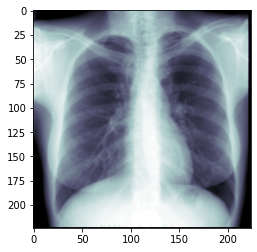

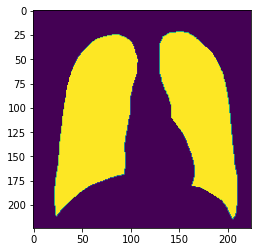

In [ ]:
#Visualization
sample = train[0]
plt.imshow(sample['image'][0],cmap="bone")
plt.show()
plt.imshow(sample['mask'][0])

In [ ]:
!pip install segmentation-models-pytorch

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])


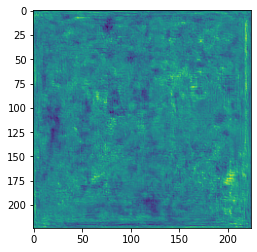

In [ ]:
import segmentation_models_pytorch as smp

model = smp.Unet('resnet34', classes=1)

print(sample['image'].shape)
print(sample['image'].unsqueeze(0).shape)
res = model(sample['image'].unsqueeze(0))
plt.imshow(res.detach().numpy()[0,0])

## **Task 2:**
- Your task is to create training loop and train some model to output segmentation. We won't judge model quality, just the corectness of training loop. To get some inspiration:
- Given: Dataset class for lung segmentation
- Do: Create training loop, which will fit **any** segmentation model with proper loss function. 


- https://www.learnopencv.com/pytorch-for-beginners-semantic-segmentation-using-torchvision/
- https://medium.com/analytics-vidhya/pytorch-implementation-of-semantic-segmentation-for-single-class-from-scratch-81f96643c98c

In [ ]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, num_workers=1)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, num_workers=1)

In [ ]:
import torch.optim as optim

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.003, momentum= 0.9)

In [ ]:
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    model.cuda()

In [ ]:
n_epochs = 20 

for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    
    model.train()
    for batch_idx, batch_data in enumerate(train_loader):
      data, mask = batch_data['image'].cuda(), batch_data['mask'].cuda()
      output = model(data)
      optimizer.zero_grad()
      loss = criterion(output, mask)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()*data.size(0)
        
    train_loss = train_loss/len(train_loader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

Epoch: 1 	Training Loss: 0.716223
Epoch: 2 	Training Loss: 0.580475
Epoch: 3 	Training Loss: 0.486930
Epoch: 4 	Training Loss: 0.402002
Epoch: 5 	Training Loss: 0.326310
Epoch: 6 	Training Loss: 0.259113
Epoch: 7 	Training Loss: 0.206406
Epoch: 8 	Training Loss: 0.168021
Epoch: 9 	Training Loss: 0.140498
Epoch: 10 	Training Loss: 0.119849
Epoch: 11 	Training Loss: 0.105282
Epoch: 12 	Training Loss: 0.093948
Epoch: 13 	Training Loss: 0.085279
Epoch: 14 	Training Loss: 0.077814
Epoch: 15 	Training Loss: 0.071238
Epoch: 16 	Training Loss: 0.065875
Epoch: 17 	Training Loss: 0.061503
Epoch: 18 	Training Loss: 0.057246
Epoch: 19 	Training Loss: 0.054065
Epoch: 20 	Training Loss: 0.051333


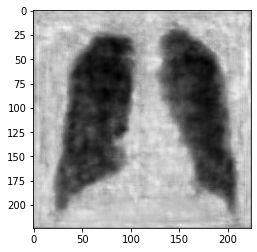

In [ ]:
res = model(train[0]['image'].unsqueeze(0).cuda())
plt.imshow(res.cpu().detach().numpy()[0][0], cmap='Greys')

In [ ]:
test_loss = 0.0
    
model.eval()
for batch_idx, batch_data in enumerate(test_loader):
  data, mask = batch_data['image'].cuda(), batch_data['mask'].cuda()
  output = model(data)
  loss = criterion(output, mask)
  test_loss += loss.item()*data.size(0)
        
  test_loss = test_loss/len(test_loader.dataset)

print('Test Loss (Overall): {:.6f}'.format(test_loss))

Test Loss (Overall): 0.047895
